In [1]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import random
random.seed(13)

#visualisation stuff
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
%matplotlib inline
import seaborn as sns
from utils import Data_load_utils
import os
import xml.etree.ElementTree as et

## Data Loading & Manipulation

In [136]:
# Load data 
PATH = "../DS4D-Trade-Agreement-Project/xml/"
extension = ".xml"

files = Data_load_utils.load_order(PATH, extension)

In [145]:
def xml2list_text(file):
    """
    Custom function for parsing and outputing the data into arrays.
    Returns two array's the extracted column names and content for each column.
    """

    parsed_xml = et.parse(file)
    root = parsed_xml.getroot()
    chapters = []
    article_store = []
    
    treaty_text = ''
    
    for item in root[1]:
        chapter_name = item.attrib.get('name')
#         print("chapter: " + item.attrib.get('name'))
        chapters.append(chapter_name)
        if chapter_name == None:
            continue
        treaty_text += chapter_name + "\n"
        
        articles = item.findall("article")
        for article in articles:
#             print(article.attrib.get('name'))
            art_no = article.attrib.get('number')
            art_text =  article.text
            article_store.append(art_no)
            if art_no == None:
                continue
#             print(art_no)
            treaty_text += art_no + "\n"
            treaty_text += art_text + "\n"
        
            
    return len(chapters), len(article_store), treaty_text

In [146]:
chapter_no, article_no, text = xml2list_text(PATH + files[2])


In [147]:
textdf = pd.DataFrame()

chapter_numbers = []
article_numbers = []
treaty_text = []

for i in range(0, len(files)):
    chapter_no, article_no, text = xml2list_text(PATH + files[i])
    chapter_numbers.append(chapter_no)
    article_numbers.append(article_no)
    treaty_text.append(text)

textdf["chapter_number"] = chapter_numbers
textdf["article_number"] = article_numbers
textdf["treaty_text"] = treaty_text


In [148]:
dfcols, null = Data_load_utils.xml2list(PATH + files[3])
totadf = pd.DataFrame(columns=dfcols)

for i in range(0, len(files)):
    dfcolstmp, datatmp = Data_load_utils.xml2list(PATH + files[i])
    tmp_df = pd.DataFrame([datatmp], columns=dfcolstmp)
    tmp_df = tmp_df.loc[:,~tmp_df.columns.duplicated()] #very important! removes duplicate columns note that it removes the multiple "source" columnsns
    totadf = totadf.loc[:,~totadf.columns.duplicated()]#very important! removes duplicate columns note that it removes the multiple "source" columnsns 
    totadf = pd.concat([totadf,tmp_df], axis=0, sort=False)
totadf = totadf.reset_index(drop=True)
totadf = pd.concat([totadf, textdf], axis=1)

In [149]:
totadf['year_signed'] = totadf.date_signed.map( lambda x: pd.to_datetime(x).year)

In [150]:
totadf = totadf[totadf.language == 'en']
totadf['language'].unique()

array(['en'], dtype=object)

In [151]:
totadf = totadf.drop(['name', 'wto_rta_id', 'status', 'notification', 'date_signed', 'date_into_force', 'end_implementation', 'parties', 'type', 'parties_original','date_inactive','date_notification', 'composition', 'region', 'parties_wto', 'crossregional', 'related_agreement_wto_id', 'language', 'source'], axis=1)

In [152]:
totadf = totadf.reset_index()
totadf.head()

,index,treaty_identifier,chapter_number,article_number,treaty_text,year_signed
0,0,1,17,175,Preamble\nGeneral Provisions\nARTICLE 1\nThe o...,2007
1,1,2,8,40,Preamble\nARTICLE 1\nThe Parties shall gradual...,2005
2,2,3,21,201,Preamble\nGeneral Provisions\nARTICLE 1\nThe P...,2007
3,3,4,3,0,,2006
4,4,5,11,52,Preamble\nGeneral Provisions\nARTICLE 1\n1. Eg...,2007


## DATA Loading & Manipulation complete

## Non-Negative Matrix Factorization (NMF)

In [153]:
# Parameters that I tweaked - could probably spend a whole week trying to find the best combination - but this selection seems to work just fine
n_features = 1000
n_topics = 5
n_top_words = 100


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
#I convert a collection of raw documents into a matrix of TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,max_features=n_features,stop_words='english')
#retearns a term-document matrix
tfidf = tfidf_vectorizer.fit_transform(totadf['treaty_text'])
# This is where the non negative matrix factorization happens - in short it is a form of dimensionality reduction
nmf = NMF(n_components=n_topics, random_state=0,alpha=.1, l1_ratio=.5).fit(tfidf)

print("Topics found via NMF:")
# need to print the works most related to the seperate topics - quite difficult to differentiate by hand. 
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topics found via NMF:

Topic #0:
shall agreement article parties party measures trade committee joint products provisions duties accordance force customs conditions imports paragraph date concerned apply appropriate effect entry consultations having referred equivalent agricultural request applied restrictions wto necessary originating particular goods difficulties laid undertakings rules 1994 information introduced implementation protection practice international rights gatt annex respective situation product turkey agreements public intellectual including property procedure considers state quantitative efta charges subject taken abolished exports period provided payments ensure taking procedures related articles relating protocol purpose duty obligations general internal aid view set chapter economic operation safeguard following conformity industrial application basic thereof enter cause

Topic #1:
party shall article good parties agreement chapter service services goods means terri

In [154]:
nmf_embedding = nmf.transform(tfidf)
nmf_embedding = (nmf_embedding - nmf_embedding.mean(axis=0))/nmf_embedding.std(axis=0)

In [155]:
# return the most representative documents for the different topics (they are classified by their treaty identifier)
top_idx = np.argsort(nmf_embedding, axis=0)[-3:]

count = 0
for idxs in top_idx.T:
    print("\nTopic {}:".format(count))
    for idx in idxs:
        print(totadf.iloc[idx]['treaty_identifier'])
    count += 1


Topic 0:
304
292
295

Topic 1:
342
144
387

Topic 2:
231
235
220

Topic 3:
195
177
256

Topic 4:
15
267
440


In [156]:
topics = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'] #these are hand coded topics and probably do not represent the actual topics 

## t-distributed Stochastic Neighbor Embedding

In [157]:
# here I use tsne to visualize the high dimensional data created by the nmf.
tsne = TSNE(n_iter=5000, random_state=3211,learning_rate=100, perplexity=60) #
tsne_embedding = tsne.fit_transform(nmf_embedding)
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
tsne_embedding['hue'] = nmf_embedding.argmax(axis=1)
tsne_embedding['year'] = totadf['year_signed']

## Plotting

In [158]:
color_list = plt.cm.Set3(np.linspace(0, 1, n_topics))

legend_list = []

for i in range(len(topics)):   
    color = color_list[i]
    legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))

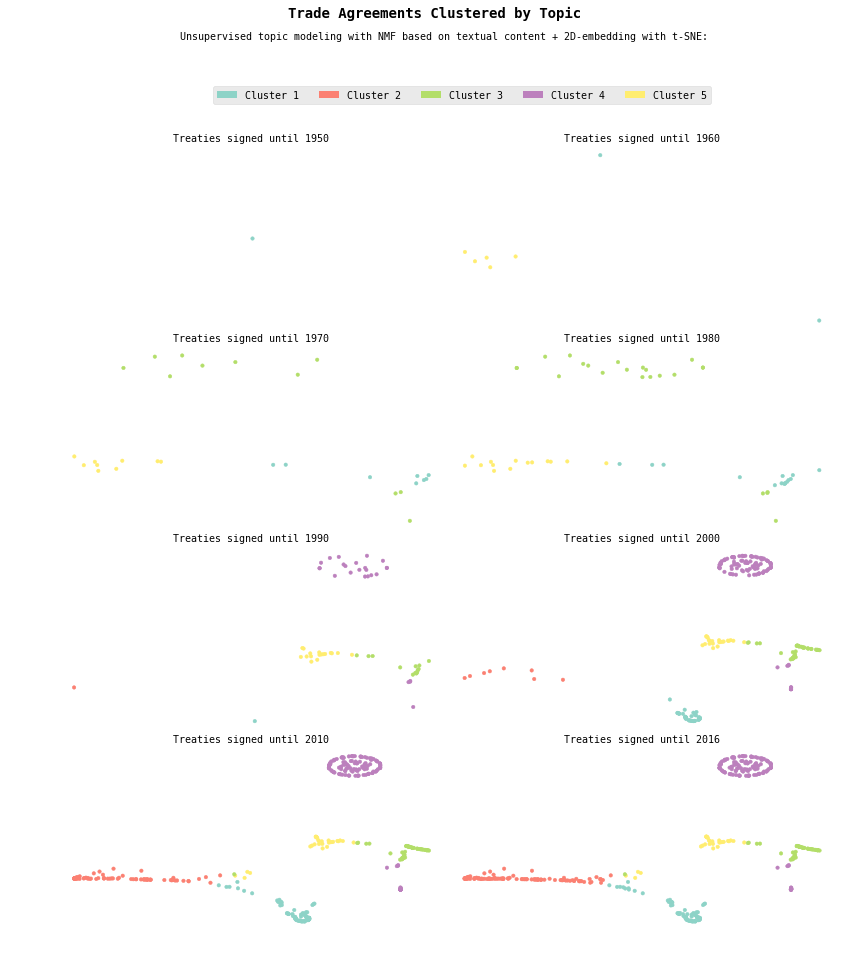

In [159]:
matplotlib.rc('font',family='monospace')
plt.style.use('ggplot')

fig, axs = plt.subplots(ncols=2,nrows=4,figsize=(14, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=0)

axs = axs.ravel()

count = 0
legend = []
for year, idx in zip([1950,1960,1970,1980,1990,2000,2010,2016], range(8)):
    data = tsne_embedding[totadf['year_signed']<=year]
#     totadf.to_csv(year.csv, sep=",")
#     print(data)
    scatter = axs[idx].scatter(data=data,x='x',y='y',s=12,c=data['hue'], cmap='Set3')
    axs[idx].set_title('Treaties signed until {}'.format(year),**{'fontsize':'10'})
    axs[idx].axis('off')

plt.suptitle("Trade Agreements Clustered by Topic",**{'fontsize':'14','weight':'bold'})
plt.figtext(.51,0.95,'Unsupervised topic modeling with NMF based on textual content + 2D-embedding with t-SNE:', **{'fontsize':'10','weight':'light'}, ha='center')


fig.legend(legend_list, topics, loc=(0.25,0.89), ncol=5)
plt.subplots_adjust(top=0.85)

plt.savefig('ToTa.png', format='png', dpi=1000)